In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from PIL import Image
# import os

# # 创建一个空列表来存储切片
# slices = []
# # print("Current Working Directory:", os.getcwd())

# # 读取每个切片
# for i in range(325):
#     # 打开图像文件
#     img = Image.open(f'./dataset_512/infer_new/IMG_0002_{i}.png')
    
#     # 将图像转换为numpy数组，并添加到切片列表中
#     slices.append(np.array(img))

# # 将所有切片堆叠成一个3D数组
# volume = np.stack(slices, axis=-1)

# # # 创建一个新的matplotlib图形和3D子图
# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')

# # # 对于体积中的每一个值
# # for x in range(volume.shape[0]):
# #     for y in range(volume.shape[1]):
# #         for z in range(volume.shape[2]):
# #             # 如果该值为真（即，该像素位于肺部），则添加一个立方体
# #             if volume[x, y, z]:
# #                 ax.voxels([x], [y], [z], edgecolor='k')
# # Create a boolean array indicating filled (True) or not filled (False) for each voxel
# filled = volume.astype(bool)
# # Convert the list comprehension to a NumPy array
# filled_array = np.array([[[filled[x, y, z] for z in range(volume.shape[2])] for y in range(volume.shape[1])] for x in range(volume.shape[0])])

# # Create a new matplotlib figure and 3D subplot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Use the ax.voxels function with facecolors, edgecolors, and the filled array
# ax.voxels(filled_array, facecolors='r', edgecolors='k')

# plt.show()




In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Function to load and process a single image
def process_image(i):
    img = Image.open(f'./dataset_512/infer_new/IMG_0002_{i}.png')
    return np.array(img)

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    # Use list comprehension for concurrent loading
    futures = [executor.submit(process_image, i) for i in range(325)]

    # Create a tqdm progress bar with the total number of tasks
    progress_bar = tqdm(total=len(futures), desc="Processing Images")

    # Iterate over completed futures as they finish
    for future in as_completed(futures):
        # Get the result from the completed future
        result = future.result()

        # Update the progress bar
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

# Stack the slices into a 3D array
volume = np.stack([future.result() for future in futures], axis=0)


# Downsample the volume for faster plotting
downsample_rate = 5
volume_downsampled = volume[::downsample_rate, ::downsample_rate, ::downsample_rate]

# # Create a new matplotlib figure and 3D subplot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # Use the ax.voxels function with facecolors, edgecolors, and the filled array
# ax.voxels(volume_downsampled, facecolors='r', edgecolors='k')

# plt.show()


Processing Images: 100%|██████████| 325/325 [00:00<00:00, 27461.80it/s]


In [27]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    # Check the range of the volume data
    min_val = p.min()
    max_val = p.max()

    # Ensure the threshold is within the range of the volume data
    threshold = max(min_val, min(threshold, max_val))
    
    # Check if the threshold value exists in the volume
    if np.any(p == threshold):
        verts, faces = measure.marching_cubes(p, threshold)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces], alpha=0.70)
        face_color = [0.45, 0.45, 0.75]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])

        plt.show()
    else:
        print(f"No values matching the threshold ({threshold}) found in the volume.")


In [28]:
print(volume.shape)
plot_3d(volume,threshold=400)

(325, 256, 256)


RuntimeError: No surface found at the given iso value.

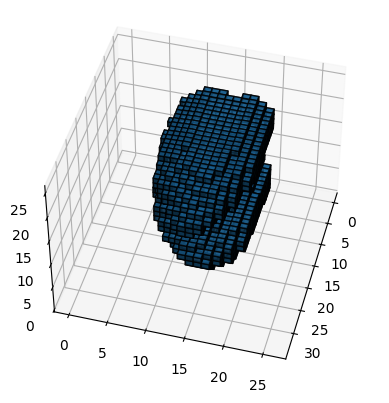

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个新的3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 创建一个3D数组来表示肺部的体积
# 注意：这里我们假设volume_downsampled已经包含了肺部的数据
# volume_downsampled = np.ones((50, 50, 50))
# print(volume_downsampled.shape)

# 创建一个表示x, y, z坐标的网格
x, y, z = np.mgrid[:volume_downsampled.shape[0]+1, :volume_downsampled.shape[1]+1, :volume_downsampled.shape[2]+1]
# print(x.shape, y.shape, z.shape)
# 使用体积数据创建一个体素图
ax.voxels(x, y, z, volume_downsampled, alpha=0.8, edgecolor='k')

# 设置视图的方位和高度
ax.view_init(45, 15)

plt.show()


In [1]:
import numpy as np
import pyvista as pv
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Function to load and process a single image
def process_image(i):
    img = Image.open(f'./dataset_512/infer_new/IMG_0002_{i}.png')
    return np.array(img)

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    # Use list comprehension for concurrent loading
    futures = [executor.submit(process_image, i) for i in range(325)]

    # Create a tqdm progress bar with the total number of tasks
    progress_bar = tqdm(total=len(futures), desc="Processing Images")

    # Iterate over completed futures as they finish
    for future in as_completed(futures):
        # Get the result from the completed future
        result = future.result()

        # Update the progress bar
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

# Stack the slices into a 3D array
volume = np.stack([future.result() for future in futures], axis=0)

# 创建一个PyVista的结构化网格
grid = pv.ImageData()

# 设置网格的维度
grid.dimensions = volume.shape

# 设置网格的原点（左下角）
grid.origin = (0, 0, 0)  # optional

# 设置网格的间距
grid.spacing = (1, 1, 1)  # optional

# 添加标量数据
grid.point_data["values"] = volume.flatten(order="F")  # Flatten the array!

# 绘制3D模型
grid.plot(show_edges=True, opacity='linear')


Processing Images: 100%|██████████| 325/325 [00:00<00:00, 205139.02it/s]
/home/xulei/miniconda/envs/sam/lib/python3.8/site-packages/pyvista/plotting/plotter.py:151: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


: 

In [ ]:
import vtk
import numpy as np

# Convert your NumPy array to a vtkImageData object
image_data = vtk.vtkImageData()
image_data.SetDimensions(volume.shape)
image_data.SetSpacing([1.0, 1.0, 1.0])

# VTK requires a 1D array in Fortran order
volume_flat = np.asfortranarray(volume.flatten(), dtype=np.float32)

# Create a vtkFloatArray and copy the data into it
float_array = vtk.vtkFloatArray()
float_array.SetNumberOfValues(len(volume_flat))
float_array.SetArray(volume_flat, len(volume_flat), 1)

# Assign the float array to the vtkImageData object
image_data.GetPointData().SetScalars(float_array)

# Create a vtkMarchingCubes object and set its parameters
marching_cubes = vtk.vtkMarchingCubes()
marching_cubes.SetInputData(image_data)
marching_cubes.ComputeNormalsOn()
marching_cubes.SetValue(0, 400)  # Set the contour value to 400

# Create a vtkPolyDataMapper to map the polygonal data to graphics primitives
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(marching_cubes.GetOutputPort())
mapper.ScalarVisibilityOff()

# Create a vtkActor to represent the polygonal data
actor = vtk.vtkActor()
actor.SetMapper(mapper)

# Create a vtkRenderer and add the actor to it
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

# Create a vtkRenderWindow and add the renderer to it
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

# Create a vtkRenderWindowInteractor and set the render window for it
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Start the interaction
interactor.Initialize()
interactor.Start()


: 